In [19]:
import nibabel as nib
import numpy as np
import os
import glob
import h5py
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = False
import json
import pandas as pd
import seaborn as sns
import time
from scipy.stats import chisquare, wasserstein_distance
import torch
import torch.nn.functional as F
from math import exp
import numpy as np
import scipy.ndimage as ndimage
import skimage
import piq

color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'lightblue', 'limegreen', 'black', 'maroon']

color_roi_mapping = {
    "cerebellum": '#1f77b4',
    "cortex": '#ff7f0e',
    "cerebral_white_matter": '#2ca02c',
    "hippocampus": '#d62728',
    "thalamus": 'maroon',
    "caudate": '#9467bd',
    "putamen": '#8c564b', 
    "brain_stem": '#e377c2',
    "globus_pallidus": '#7f7f7f',
    "amygdala": '#bcbd22',
    "CSF": '#17becf',
    "corpus_callosum": 'lightblue'
}

TARGET_ROIS = {
        "cerebellum": [7, 8, 46, 47],
        "cortex": [3, 42],
        "cerebral_white_matter": [2, 41],
        "thalamus": [10, 49],
        "hippocampus": [17, 53],
        "caudate": [11, 50],
        "putamen": [12, 51], 
        "brain_stem": [16],
        "globus_pallidus": [13, 52],
        "amygdala": [18, 54],
        "CSF": [24],
        "corpus_callosum": [251, 252, 253, 254, 255]
    } # cerebral cortex, cerebral wm, hippocampus, caudate, 

LR_ROIS = {
    "cerebellum": {'left': [7, 8], 
                   'right': [46, 47]},
    "cortex": {'left': [3],
              'right': [42]},
    "cerebral_white_matter": {'left': [2], 
                              'right':[41]},
    "hippocampus": {'left': [17],
                   'right': [53]},
    "caudate": {'left': [11],
               'right': [50]},
    "thalamus": {'left': [10],
                'right': [49]},
    "putamen": {'left': [12],
                'right': [51]}, 
    "globus_pallidus": {'left': [13],
                        'right': [52]},
    "amygdala": {'left': [18], 
                 'right': [54]},
}

Short_names = {
    "cerebellum": "cb",
    "cortex": 'cortex',
    "hippocampus": "hippo",
    "caudate": "caudate",
    "thalamus": "tha",
    "putamen": "putamen",
    "globus_pallidus": "gp",
    "amygdala": "amygdala"
}

def norm(img, norm_type='max'):
    if norm_type == 'max':
        img = (img - img.min()) / (img.max() - img.min())
        img = np.clip(img, a_min=0, a_max=1.0)
    elif norm_type == 'mean':
        img = img / img.mean()
    return img

def compute_msssim(img1, img2):
    '''
        More accurate SSIM evaluation than skimage
    '''
    ms_ssim_index = piq.multi_scale_ssim(img1, img2, data_range=1.)
    return ms_ssim_index


def compute_roi_mask(roi_volume_labels, label_vol, shape=(256, 256, 89)):
    roi_mask = np.zeros(shape)
    for lab in roi_volume_labels:
        m = np.where(label_vol==lab, 1, 0)
        roi_mask = m + roi_mask
    return roi_mask

def compute_masks(seg_file, threshold=900):
    '''
        Mask combine left & right hemisphere
    '''
    label_vol = nib.load(seg_file).get_fdata()

    target_volume_maps = {}
    for roi in TARGET_ROIS.keys():
        val = compute_roi_mask(TARGET_ROIS[roi], label_vol)
        target_volume_maps[roi] = val
    return target_volume_maps

def compute_hemispheric_masks(seg_file):
    '''
        Separate left & right mask
        return format: 
        {
            'cerebellum': {'left': mask1, 'right': mask2},
            'thalamus': {'left', ... 'right': ...},
            .....
        }
    '''
    label_vol = nib.load(seg_file).get_fdata()
    target_rois = {
            "cerebellum": {'left': [7, 8], 
                           'right': [46, 47]},
            "cortex": {'left': [3],
                      'right': [42]},
            "cerebral_white_matter": {'left': [2], 
                                      'right':[41]},
            "hippocampus": {'left': [17],
                           'right': [53]},
            "caudate": {'left': [11],
                       'right': [50]},
            "thalamus": {'left': [10],
                        'right': [49]},
            "putamen": {'left': [12],
                        'right': [51]}, 
            "globus_pallidus": {'left': [13],
                                'right': [52]},
            "amygdala": {'left': [18], 
                         'right': [54]},
        }
    roi_maps = {}
    for roi in target_rois.keys():
        roi_maps[roi] = {'left': compute_roi_mask(target_rois[roi]['left'], label_vol),
                        'right': compute_roi_mask(target_rois[roi]['right'], label_vol)}
    return roi_maps


def global_bland_altman(combined_df, target_pet_type, true_pet_type, shared_rois, save_name):
    '''
        Bland altman for ROIs, taking a dataframe
    '''
    target_cols = [x+"_suvr" for x in shared_rois]
    pet_pred_df = combined_df[combined_df['pet_type'] == target_pet_type].sort_values(by=['subject'])[target_cols]
    pet_true_df = combined_df[combined_df['pet_type'] == true_pet_type].sort_values(by=['subject'])[target_cols]
    suvr_dict_gt_list = []
    suvr_dict_pred_list = []
    suvr_dict_gt = {}
    suvr_dict_pred = {}
    for roi in shared_rois:
        col_val = pet_pred_df[roi+'_suvr'].values
        suvr_dict_pred[roi] = col_val
        suvr_dict_pred_list.extend(col_val)
        col_val = pet_true_df[roi+'_suvr'].values
        suvr_dict_gt[roi] = col_val
        suvr_dict_gt_list.extend(col_val)
        
    # color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', 'lightblue', 'limegreen', 'black', 'maroon']
    plt.figure(figsize=(8,6))
    
    for i, lab in enumerate(suvr_dict_gt.keys()):
        # print(suvr_dict_gt[lab], suvr_dict_pred[lab])
        plt.plot(0.5*(np.array(suvr_dict_gt[lab])+np.array(suvr_dict_pred[lab])), np.array(suvr_dict_gt[lab])-np.array(suvr_dict_pred[lab]), '.', alpha=0.6, color=color_roi_mapping[lab], label=lab, markersize=10)
    
    sd196 = round(1.96*np.std(np.array(suvr_dict_gt_list)-np.array(suvr_dict_pred_list)), 2)
    mean = round(np.mean(np.array(suvr_dict_gt_list)-np.array(suvr_dict_pred_list)), 2)
    xmin = round(0.5*np.min(np.array(suvr_dict_gt_list)+np.array(suvr_dict_pred_list)), 2)
    xmax = round(0.5*np.max(np.array(suvr_dict_gt_list)+np.array(suvr_dict_pred_list)), 2)
    plt.plot([xmin, xmax], [mean+sd196, mean+sd196], color='tab:orange', linestyle='dotted')
    plt.text(xmax-0.05, mean+sd196+0.02, "%.2f" % (mean+sd196), fontsize=10)
    plt.plot([xmin, xmax], [mean-sd196, mean-sd196], color='tab:orange', linestyle='dotted')
    plt.text(xmax-0.05, mean-sd196+0.02, "%.2f" % (mean-sd196), fontsize=10)
    plt.plot([xmin, xmax], [mean, mean], color='tab:purple', linestyle='dotted')
    plt.legend(ncol=2)
    plt.text(xmax-0.05, mean+0.02, "%.2f" % mean, fontsize=10)
    plt.xlabel('Mean of methods', fontsize=14)
    plt.ylabel('Acquired - Synthesized SUVR', fontsize=14)
    # plt.savefig('global_bland_altman.png')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    
    # Adjust the plot to make room for the legend
    plt.tight_layout()
    if save_name:
        plt.savefig(save_name, bbox_inches='tight', dpi=300)
    else:
        plt.show()



def prepare_all_subjects(test_dirs, exp_types, save_dest):
    test_subjects = os.listdir(test_dirs[0])
    all_suvr_diff_df = []
    all_hemi_diff_df = []
    all_suvr_df = []
    all_subj_metrics = {}
    all_subj_suvr_diff = {}

    fig1, axes = plt.subplots(nrows=4, ncols=len(test_subjects)//4 + 1, figsize=(15,25))
    axes_flatten_1 = axes.ravel()

    fig2, axes = plt.subplots(nrows=4, ncols=len(test_subjects)//4 + 1, figsize=(15, 25))
    axes_flatten_2 = axes.ravel()
    
    
    for i, subj in enumerate(test_subjects):
        print(f"------Performing {subj}--------")
        suvr, suvr_diff, all_metrics, hemi_diff, hemi_diff_diff =  analyze_one_subj(subj, exp_types, save_dest, *test_dirs)
        plot_asymmetry(hemi_diff, subj, axes_flatten_1[i])

        suvr_df = json_to_pd_row(subj, suvr)
        suvr_diff_df = json_to_pd_row(subj, suvr_diff)
        hemi_diff_df = json_to_pd_row(subj, hemi_diff)
    
        all_suvr_diff_df.append(suvr_diff_df)
        all_suvr_df.append(suvr_df)
        all_hemi_diff_df.append(hemi_diff_df)

        all_subj_metrics[subj] = all_metrics
        all_subj_suvr_diff[subj] = suvr_diff
        plot_suvr_diff_one_subj(suvr_diff, subj, axes_flatten_2[i], save_name=None)
        print("------Done------")
        break

    # Hide any unused subplots
    for j in range(i + 1, len(axes_flatten_1)):
        fig1.delaxes(axes_flatten_1[j])
        fig2.delaxes(axes_flatten_2[j])
        
    plt.tight_layout()
    if save_dest:
        fig1.savefig(os.path.join(save_dest, "SUVR_Asymmetry.png"), bbox_inches='tight', dpi=300)
        fig1.savefig(os.path.join(save_dest, "SUVR_Differences.png"), bbox_inches='tight', dpi=300)
    else:
        fig1.show()
        fig2.show()
    
    if save_dest:
        with open(os.path.join(save_dest, "all_metrics.json"), 'w') as fw:
            json.dump(all_subj_metrics, fw, indent=4)
    
        with open(os.path.join(save_dest, "all_suvr_diff.json"), 'w') as fw:
            json.dump(all_subj_suvr_diff, fw, indent=4)

    combined_df = pd.concat(all_suvr_df, ignore_index=True)
    combined_hemi_df = pd.concat(all_hemi_diff_df, ignore_index=True)
    return combined_df, combined_hemi_df, all_subj_metrics, all_subj_suvr_diff

def compute_suvr(roi_masks, ref_name, pet, include_diff=True): # {pet1: {roi1: {'suvr': xx, ...}}, pet2: {roi1: {'suvr': xx}}}
    ref_mask = roi_masks[ref_name]
    if type(pet) == dict:
        res = {}
        res_diff = {}
        pet_data = pet['truth']
        res['truth'] = {}
        suv_ref = (pet_data * ref_mask).sum() / ref_mask.sum() # cerebellum total suv / cerebellum total volume
        for roi in roi_masks.keys():
            curr_roi_mask = roi_masks[roi]
            suv_roi = (pet_data * curr_roi_mask).sum() / curr_roi_mask.sum() # roi total suv / roi total volume
            suvr_roi = suv_roi / (suv_ref + 1e-4)
            res['truth'][roi] = {'suvr': suvr_roi}
        for p in pet.keys():
            if p == 'truth':
                continue
            res[p] = {}
            pet_data = pet[p]
            suv_ref = (pet_data * ref_mask).sum() / ref_mask.sum() # cerebellum total suv / cerebellum total volume
            for roi in roi_masks.keys():
                curr_roi_mask = roi_masks[roi]
                suv_roi = (pet_data * curr_roi_mask).sum() / curr_roi_mask.sum() # roi total suv / roi total volume
                suvr_roi = suv_roi / (suv_ref + 1e-4)
                res[p][roi] = {'suvr': suvr_roi}
                if include_diff:
                    if p not in res_diff:
                        res_diff[p] = {}
                    res_diff[p][roi] = res['truth'][roi]['suvr'] - suvr_roi # how suvr deviates from the true pet
        return res, res_diff
    else:
        raise NotImplementedError
    
def compute_metrics(all_pets):
    res = {}
    truth = all_pets['truth'][:, :, 20:71]
    for pet in all_pets.keys():
        if pet == 'truth':
            continue
        curr_pred_img = all_pets[pet][:, :, 20:71]
        psnr = skimage.metrics.peak_signal_noise_ratio(truth, curr_pred_img, data_range=1)
        ssim = skimage.metrics.structural_similarity(truth, curr_pred_img, data_range=1)
        rmse = skimage.metrics.normalized_root_mse(truth, curr_pred_img)

        slice_true_torch = torch.Tensor(truth).unsqueeze(0).permute(3, 0, 1, 2)
        slice_pred_torch = torch.Tensor(curr_pred_img).unsqueeze(0).permute(3, 0, 1, 2)
        msssim = piq.multi_scale_ssim(slice_true_torch, slice_pred_torch, data_range=1.)
        res[pet] = {'psnr': psnr, 'rmse': rmse, 'ssim': ssim, 'msssim': msssim}
        print(f"PET: {pet}, PSNR: {psnr}, MSSSIM: {msssim}, RMSE: {rmse}, SSIM: {ssim}")
    return res


def compute_asymmetry(hemisphere_roi_masks, global_roi_masks, pet, include_diff=True, ref_name='cerebellum'):
    ref_mask = global_roi_masks[ref_name]
    res = {}
    pet_data = pet['truth']
    res['truth'] = {}
    res_diff = {}
    suv_ref_global = (pet_data * ref_mask).sum() / ref_mask.sum() # global reference, i.e., both left & right cerebellum
    for roi in hemisphere_roi_masks.keys():
        curr_roi_mask_left = hemisphere_roi_masks[roi]['left']
        curr_roi_mask_right = hemisphere_roi_masks[roi]['right']
        suv_roi_left = (pet_data * curr_roi_mask_left).sum() / curr_roi_mask_left.sum() # roi total suv / roi total volume
        suvr_roi_left = suv_roi_left / (suv_ref_global + 1e-4)
        
        suv_roi_right = (pet_data * curr_roi_mask_right).sum() / curr_roi_mask_right.sum() # roi total suv / roi total volume
        suvr_roi_right = suv_roi_right / (suv_ref_global + 1e-4)
        
        res['truth'][roi] = {'left': suvr_roi_left,
                            'right': suvr_roi_right,
                            'diff': (suvr_roi_left - suvr_roi_right) / (suvr_roi_left + suvr_roi_right)}
    for p in pet.keys():
        if p == 'truth':
            continue
        res[p] = {}
        pet_data = pet[p]
        suv_ref_global = (pet_data * ref_mask).sum() / ref_mask.sum() # cerebellum total suv / cerebellum total volume
        for roi in hemisphere_roi_masks.keys():
            curr_roi_mask_left = hemisphere_roi_masks[roi]['left']
            curr_roi_mask_right = hemisphere_roi_masks[roi]['right']
            suv_roi_left = (pet_data * curr_roi_mask_left).sum() / curr_roi_mask_left.sum() # roi total suv / roi total volume
            suvr_roi_left = suv_roi_left / (suv_ref_global + 1e-4)
            
            suv_roi_right = (pet_data * curr_roi_mask_right).sum() / curr_roi_mask_right.sum() # roi total suv / roi total volume
            suvr_roi_right = suv_roi_right / (suv_ref_global + 1e-4)
            res[p][roi] = {'left': suvr_roi_left,
                           'right': suvr_roi_right,
                           'diff': (suvr_roi_left - suvr_roi_right) / (suvr_roi_left + suvr_roi_right)}
            if include_diff:
                if p not in res_diff:
                    res_diff[p] = {}
                res_diff[p][roi] = {'left': res['truth'][roi]['left'] - res[p][roi]['left'],
                                   'right': res['truth'][roi]['right'] - res[p][roi]['right'],
                                    'diff': res['truth'][roi]['diff'] - res[p][roi]['diff'],
                                   }
    return res, res_diff


def get_histogram(data, num_bins=64, scale=10, output='norm'):
     # calculate histogram
    histograms, _ = np.histogram(data, bins=num_bins, range=(0.001, 1))
    normalized_histograms = histograms / (histograms.sum(keepdims=True) + 1e-4)
    normalized_histograms *= scale
    if output == 'norm':
        return normalized_histograms
    cum_hist = np.cumsum(normalized_histograms)
    hist_diff = np.diff(normalized_histograms)
    hist_diff = np.insert(hist_diff, 0, hist_diff[0])
    hist_diff *= scale
    combined_histogram = np.stack((normalized_histograms, cum_hist, hist_diff), axis=0) # 3, 128
    # assert combined_histogram.shape == (3, 128)
    return combined_histogram
    
def compare_histograms(vol1, vol2, roi_name, pet_type, num_bins=128):
    '''
        Evaluate histogram with Wasserstein loss, can be a single slice or a whole volume
    '''
    hist1 = get_histogram(vol1, num_bins, output='all')[0]
    hist2 = get_histogram(vol2, num_bins, output='all')[0]
    # chi-square, may give nan value
    # chi_square, p_value = chisquare(hist1, hist2)
    # print(chi_square, p_value)
    emd = wasserstein_distance(hist1, hist2)
    plt.clf()
    plt.subplot(121)
    plt.bar(range(num_bins), hist1, width=3)
    plt.subplot(122)
    plt.bar(range(num_bins), hist2, width=3)
    plt.title(f"{pet_type} {roi_name} Asymmetry Wasserstein {emd}")
    plt.show()
    # Wasserstein distance
    print(f'{pet_type} {roi_name} EMD: {emd}')
    return emd

def compare_histogram_asymmetry(roi_masks, pets, num_bins=128):
    res = {}
    for roi, val in roi_masks.items():
        roi_mask_left = val['left']
        roi_mask_right = val['right']
        if roi not in res:
            res[roi] = {}
        for pet_type, pet_vol in pets.items():
            vol_left = pet_vol * roi_mask_left
            vol_right = pet_vol * roi_mask_right
            distance = compare_histograms(vol_left, vol_right, roi, pet_type)
            res[roi][pet_type] = distance
    return res


def analyze_one_subj(subj, pet_types, save_dest, *test_dirs):
    '''
        Computes SUVR, PSNR, RMSE, MSSSIM, SUVR-asymmetry, histogram-asymmetry
    '''
    seg_file = os.path.join("/data/jiaqiw01/PET_MRI/data/segmentation", subj, "aseg.nii")
    roi_masks_global = compute_masks(seg_file)
    roi_masks_left_right = compute_hemispheric_masks(seg_file)
    pet_truth = sorted(glob.glob(os.path.join("/data/jiaqiw01/preprocessed_cases", subj, 'reslice_PET_full.nii')))
    if len(pet_truth) == 0:
        pet_truth = sorted(glob.glob(os.path.join("/data/jiahong/data/FDG_PET_preprocessed", subj, 'reslice_PET_*.nii')))
        
    pet_truth = pet_truth[0]
    print(pet_truth)
    pets = {'truth': nib.load(pet_truth).get_fdata()}
    # normalize to 0-1
    temp = np.zeros((256, 256, 89))
    temp[:, :, 20:71] = pets['truth'][:, :, 20:71]
    pets['truth'] = norm(temp)
    
    # idx = 1
    for i, directory in enumerate(test_dirs):
        pet_data = list(glob.glob(os.path.join(directory, subj) + "/*.nii"))
        if pet_data == []:
            print(f"Could not find predicted pet file for {subj}")
            continue
        curr_pred_pet = nib.load(pet_data[0]).get_fdata()
        if curr_pred_pet.shape != (256, 256, 89):
            padded = np.zeros((256, 256, 89))
            padded[:, :, 20:71] = curr_pred_pet
            curr_pred_pet = padded
        else:
            temp = np.zeros((256, 256, 89))
            temp[:, :, 20:71] = curr_pred_pet[:, :, 20:71]
        # normalize to 0-1
        pets[pet_types[i]] = norm(curr_pred_pet)
        # fname = f'{save_dest}/{subj}_{pet_types[i]}_slice_visualization.png'
        # print("====Plotting Slice Visualization====")
        # plot_slice_visulization(subj, curr_pred_pet, pets['truth'], roi_masks, fname)

    suvr, suvr_diff = compute_suvr(roi_masks_global, 'cerebellum', pets, include_diff=True)
    all_metrics = compute_metrics(pets)
    suvr_hemi_diff, suvr_hemi_diff_diff = compute_asymmetry(roi_masks_left_right, roi_masks_global, pets)
    
    histogram_hemi_diff = compare_histogram_asymmetry(roi_masks_left_right, pets)
                                    
    return suvr, suvr_diff, all_metrics, suvr_hemi_diff, suvr_hemi_diff_diff

def json_to_pd_row(subj, res):
    dfs = []
    for k, v in res.items():
        json_v = pd.json_normalize(v, sep='_')
        json_v['pet_type'] = k
        dfs.append(json_v)
    df = pd.concat(dfs, ignore_index=True)
    df['subject'] = subj
    col = df.pop("pet_type")
    df.insert(0, col.name, col)
    col = df.pop("subject")
    df.insert(0, col.name, col)
    return df


def plot_suvr_diff_one_subj(suvr_diff_dict, subj, ax, ignore_roi=['cerebellum'], save_name="test_suvr_diff_barplot.png"):
    for ignore in ignore_roi:
        if ignore in list(suvr_diff_dict.keys()):
            del suvr_diff_dict[ignore]
    diff_df = pd.DataFrame.from_dict(suvr_diff_dict).reset_index()
    pet_types = list(suvr_diff_dict.keys())
    diff_df_melted = pd.melt(diff_df, id_vars=['index'], value_vars=pet_types)
    sns.set_context("paper")
    sns.set_style("darkgrid")
    sns.barplot(diff_df_melted, x='index', y='value', hue='variable', ax=ax)
    ax.set_title(f"SUVR Difference Subject {subj}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, fontsize=10)
    plt.tight_layout()
    # if save_name:
    #     plt.savefig(save_name, bbox_inches='tight', dpi=300)
    # else:
    #     plt.show()
    # return ax

def plot_slice_visulization(subj, pred, target, roi_masks, save, slice_idx=[40, 44, 48], target_rois=['cerebral_white_matter', 'cortex']):
    # idx = target.shape[-1]//2
    nrow = len(target_rois)
    ncol = len(slice_idx)
    print(nrow, ncol)
    fig, axes = plt.subplots(2, ncol, figsize=(12, 8))
    flatten_axes = axes.flatten()
    axes_idx = 0
    used_axes_idx = []
    for idx in slice_idx:
        pred_slice = pred[:, :, idx]
        target_slice = target[:, :, idx]
        dim_roi_mask_comb = np.zeros(target_slice.shape)
        for roi in target_rois:
            roi_mask_slice = roi_masks[roi][:, :, idx]
            dim_roi_mask = np.where(roi_mask_slice==1, 1, 0)
            dim_roi_mask_comb += dim_roi_mask

        target_img = dim_roi_mask_comb * target_slice 
        pred_img = dim_roi_mask_comb * pred_slice

        flatten_axes[axes_idx].imshow(pred_img, cmap='gray')
        flatten_axes[axes_idx].set_title(f"Slice {idx} Pred")
        flatten_axes[axes_idx].axis("off")
        used_axes_idx.append(axes_idx)

        flatten_axes[axes_idx + ncol].imshow(target_img, cmap='gray')
        flatten_axes[axes_idx + ncol].set_title(f"Slice {idx} Target")
        flatten_axes[axes_idx + ncol].axis("off")
        used_axes_idx.append(axes_idx + ncol)
        axes_idx += 1

    # for j in range(len(axes)):
    #     if j not in used_axes_idx:
    #         fig.delaxes(axes[j])
    rois = '_'.join(target_rois)
    fig.suptitle(f"{rois} Comparison Subject {subj}")
    plt.tight_layout()
    plt.savefig(save, dpi=300, bbox_inches='tight')

def plot_asymmetry(info, subj, ax, save_name=None):
    sns.set_context("paper")
    sns.set_style("darkgrid")
    preds = list(info.keys())
    # print(preds)
    all_rois = list(LR_ROIS.keys())
    all_names = [Short_names[x] for x in all_rois]
    all_pred = [[] for _ in range(len(preds))]

    for i, pred in enumerate(preds):
        for roi in all_rois:
            pred_diff = info[pred][roi]['diff']
            all_pred[i].append(pred_diff)
    
    # print(all_rois, all_pred)

    bar_width = 0.8 / (len(preds)+1)
    r1 = np.arange(len(all_rois))
    
    # Creating the bar plot
    colors = color_list[:len(preds)]
    labels = preds
    
    for i in range(len(all_pred)):
        r = [x + bar_width * i for x in r1]
        ax.bar(r, all_pred[i], color=colors[i], width=bar_width, edgecolor='grey', label=labels[i])
    
    # Adding the labels
    ax.set_xlabel('ROI Name', fontweight='bold')
    ax.set_xticks([r + bar_width / 2 for r in range(len(all_rois))], all_names, rotation=30, fontsize=10)

    # Adding the legend
    ax.legend()
    ax.set_title(f"SUVR Asymmetry for Subject {subj}")
    # if save_name:
    #     plt.tight_layout()
    #     plt.savefig(save_name, bbox_inches='tight', dpi=400)
    # else:
    #     plt.show()
    # return fig


------Performing 25120--------
/data/jiaqiw01/preprocessed_cases/25120/reslice_PET_full.nii
PET: vpsde_dds_step_100, PSNR: 23.386286711828163, MSSSIM: 0.8937812447547913, RMSE: 0.4498536106955286, SSIM: 0.42946003623611056


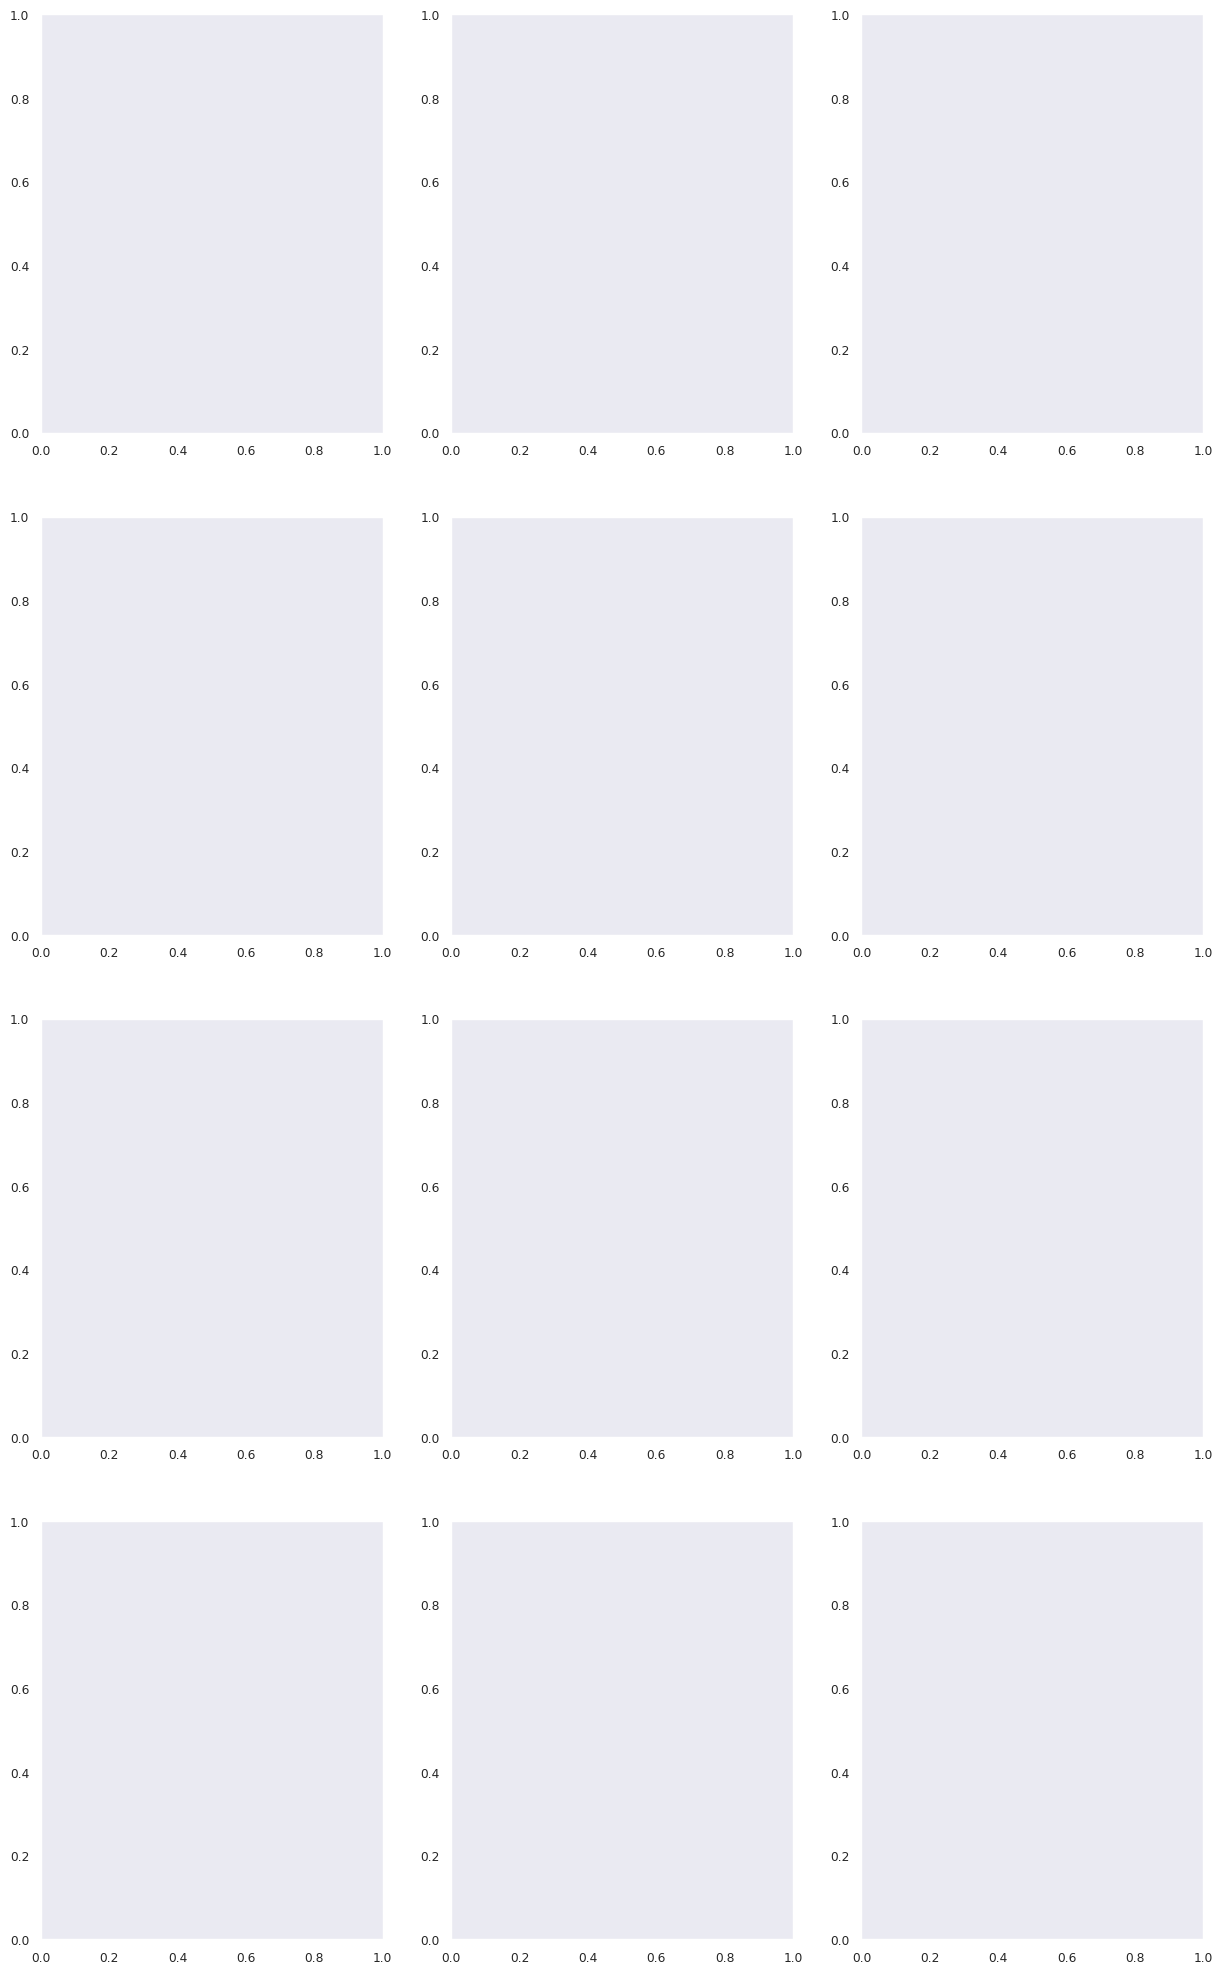

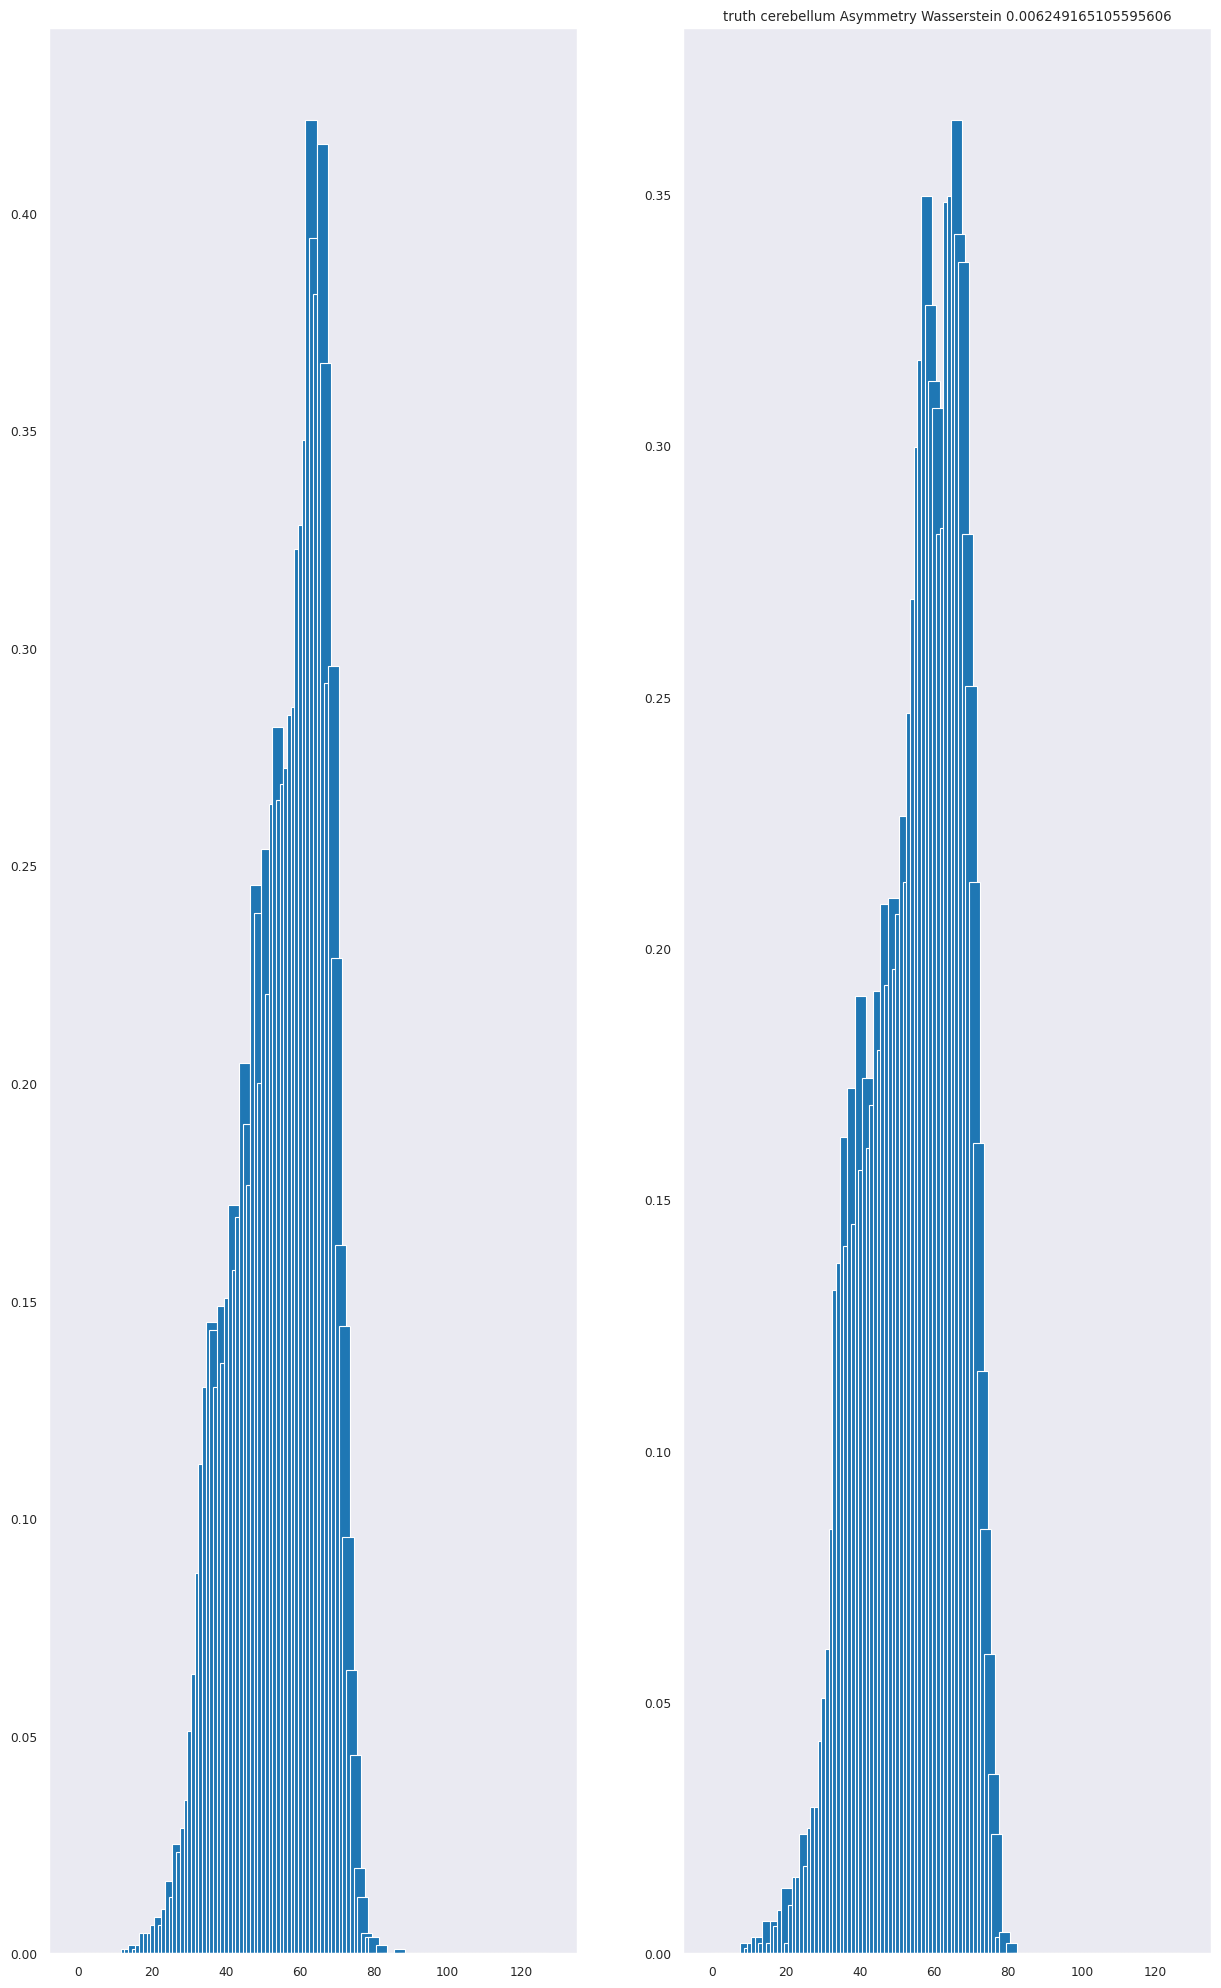

truth cerebellum EMD: 0.006249165105595606


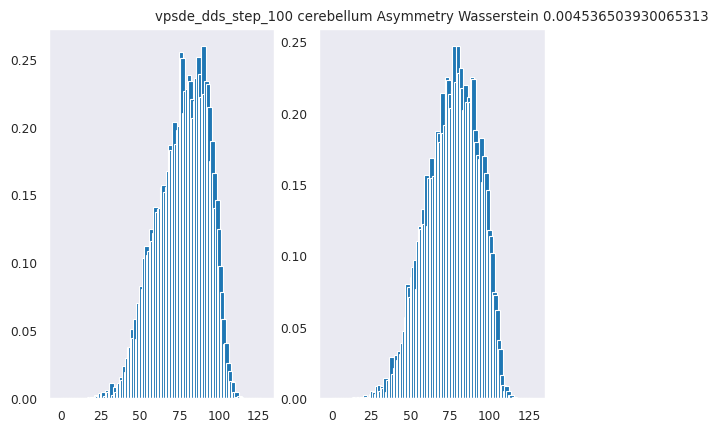

vpsde_dds_step_100 cerebellum EMD: 0.004536503930065313


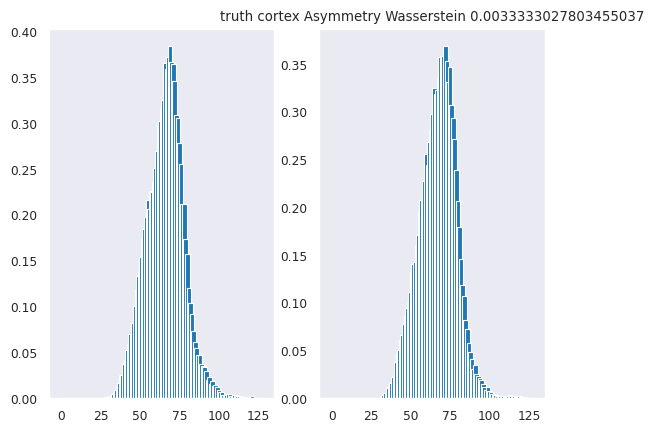

truth cortex EMD: 0.0033333027803455037


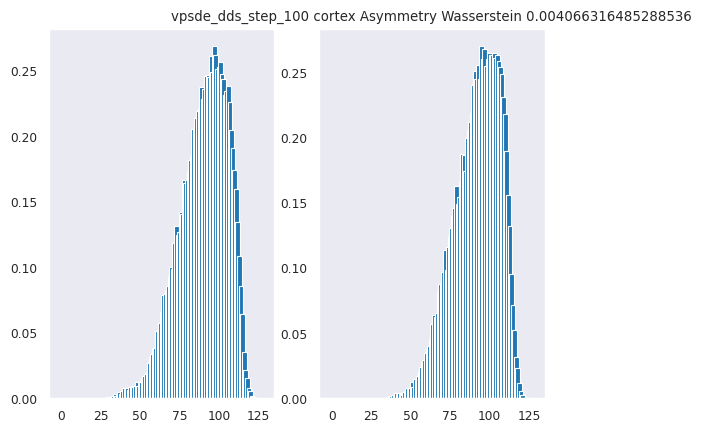

vpsde_dds_step_100 cortex EMD: 0.004066316485288536


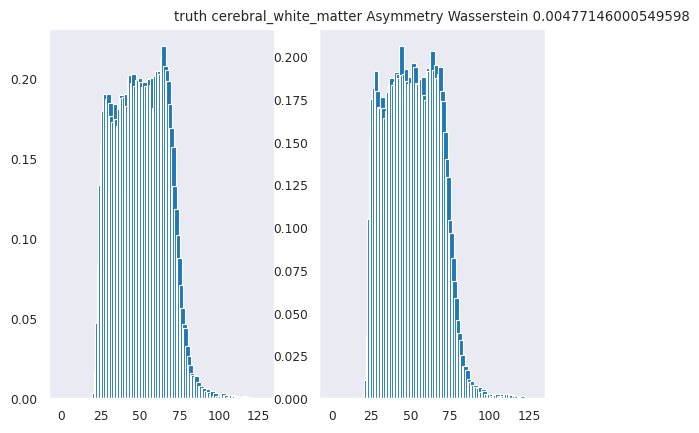

truth cerebral_white_matter EMD: 0.00477146000549598


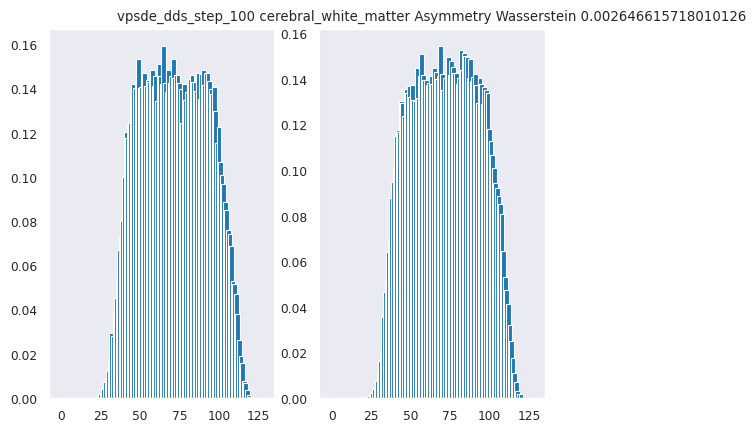

vpsde_dds_step_100 cerebral_white_matter EMD: 0.002646615718010126


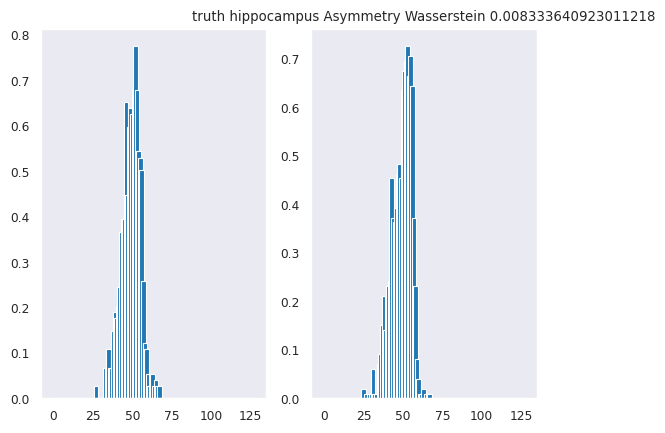

truth hippocampus EMD: 0.008333640923011218


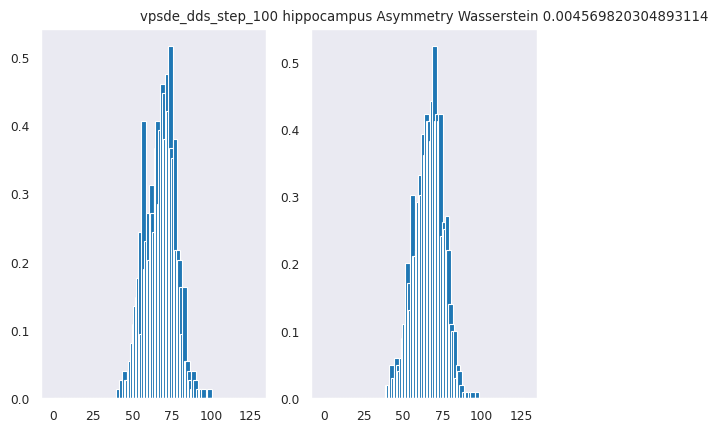

vpsde_dds_step_100 hippocampus EMD: 0.004569820304893114


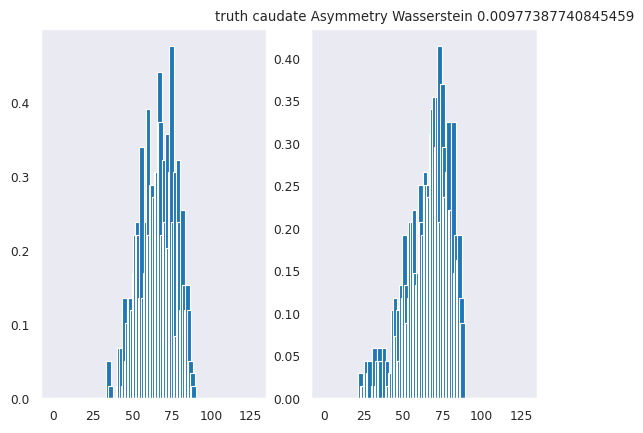

truth caudate EMD: 0.00977387740845459


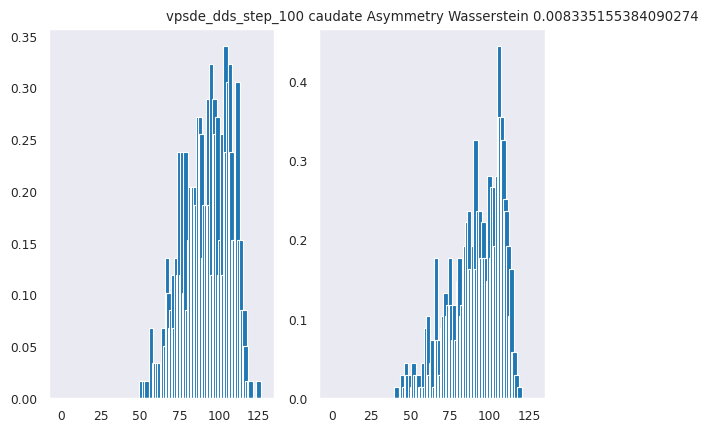

vpsde_dds_step_100 caudate EMD: 0.008335155384090274


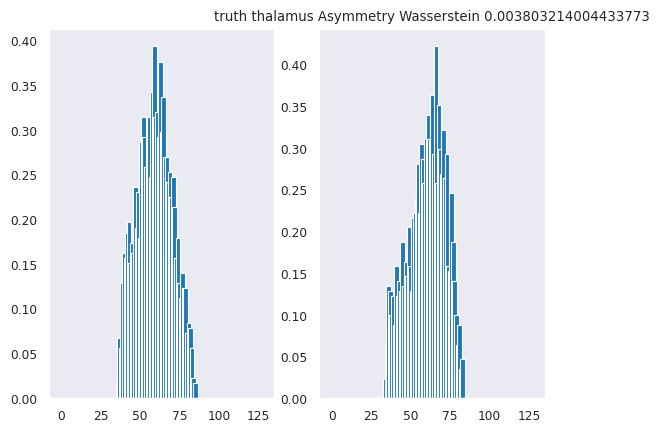

truth thalamus EMD: 0.003803214004433773


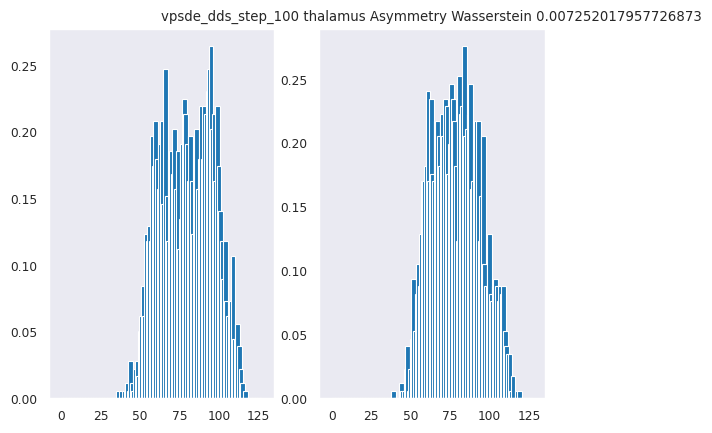

vpsde_dds_step_100 thalamus EMD: 0.007252017957726873


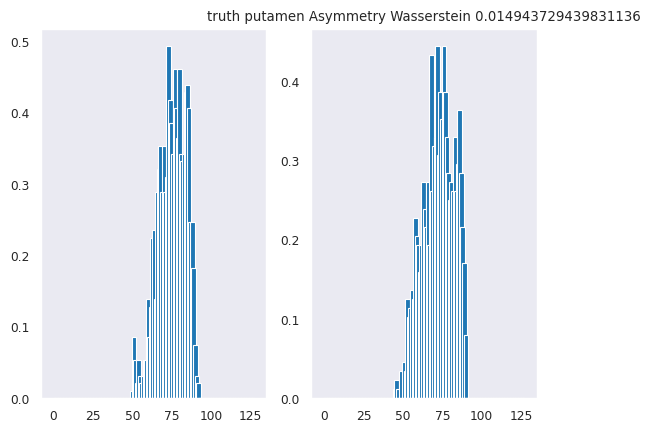

truth putamen EMD: 0.014943729439831136


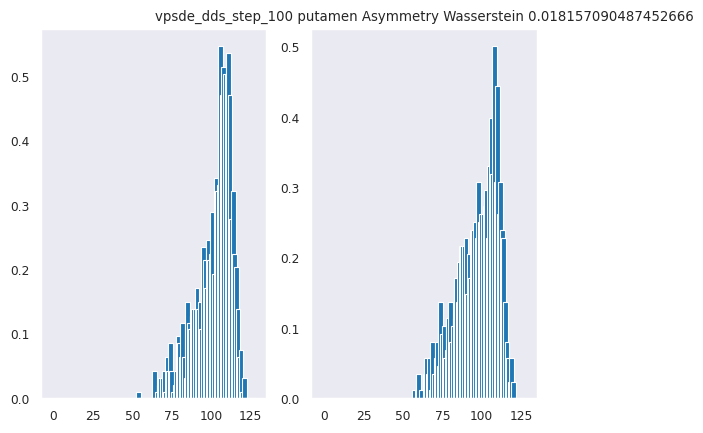

vpsde_dds_step_100 putamen EMD: 0.018157090487452666


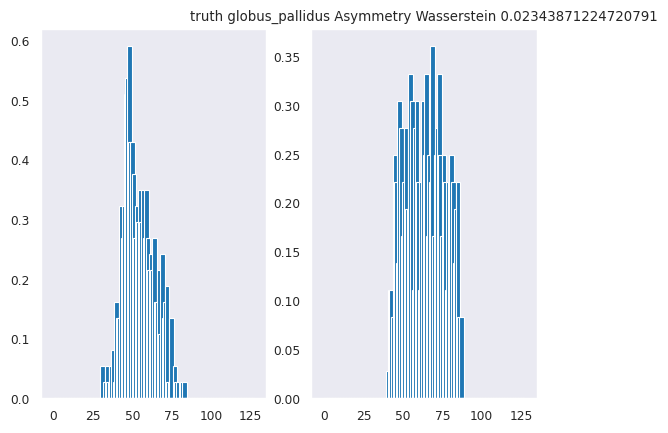

truth globus_pallidus EMD: 0.02343871224720791


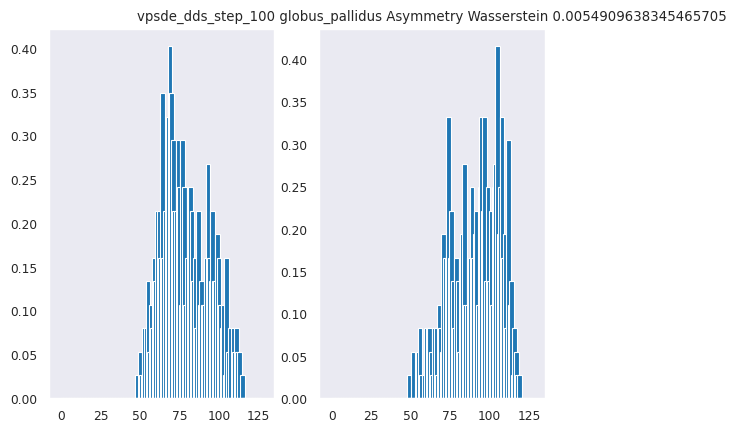

vpsde_dds_step_100 globus_pallidus EMD: 0.0054909638345465705


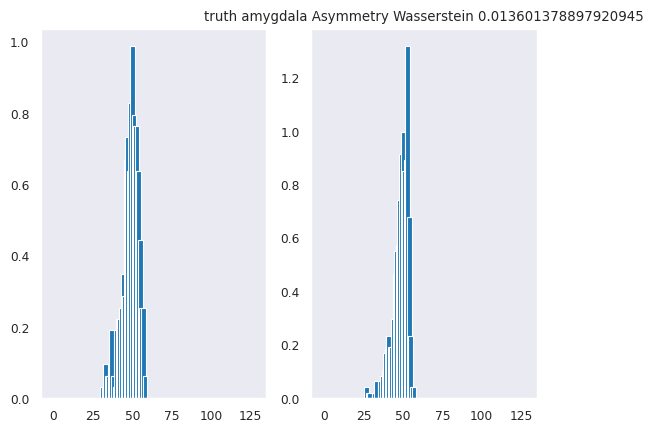

truth amygdala EMD: 0.013601378897920945


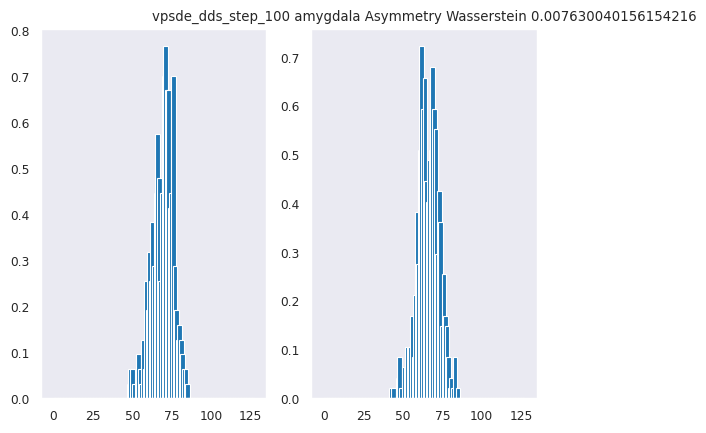

vpsde_dds_step_100 amygdala EMD: 0.007630040156154216


KeyError: 'cerebral_white_matter'

In [20]:
test_dir = ['/data/jiaqiw01/all_exp_tests/score_vpsde_dds_step_100']
exp_types = ['vpsde_dds_step_100']

combined_suvr_df, combined_hemi_diff_df, all_subj_metrics, all_subj_suvr_diff = prepare_all_subjects(test_dir, exp_types, None)



In [ ]:

# subj = '25120'

# pets = {'truth': norm(nib.load("/data/jiaqiw01/preprocessed_cases/25120/reslice_PET_full.nii").get_fdata()),
#        'vpsde_dds_step_100': norm(nib.load("/data/jiaqiw01/all_exp_tests/score_vpsde_dds_step_100/25120/25120_pred.nii").get_fdata())}

# seg_file = os.path.join("/data/jiaqiw01/PET_MRI/data/segmentation", subj, "aseg.nii")
# roi_masks_global = compute_masks(seg_file)
# roi_masks_left_right = compute_hemispheric_masks(seg_file)

# compare_histogram_asymmetry(roi_masks_left_right, pets)

[0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 1.
 0.99999999 0.99999999 0.99999999] [0.99986658 0.99985334 0.99985775 0.99985656 0.99984096 0.99986715
 0.99986083 0.99984418 0.99984793]
[0.97316886 0.97785375 1.33395985 1.20912552 1.38391992 0.89608052
 1.09319161 1.33922399 1.09402303] [0.95046121 1.0276045  1.18100687 1.18509714 1.30757607 0.85907262
 1.05171656 1.26803307 1.21819076]
[0.94111337 1.01799517 0.9982037  0.92856729 1.03375843 1.0740172
 0.84690141 1.05397774 0.8689979 ] [0.92131431 1.05122525 0.9212363  0.94169873 1.0219422  0.96647057
 0.91574482 1.01808725 1.02901456]
[0.96543532 1.08333844 1.21534965 1.08323099 1.17251867 1.22726424
 1.05080632 1.14682525 1.01710607] [1.00856029 1.09834998 1.05317794 1.03560408 1.0849039  1.05951081
 1.0982626  1.14339366 1.16256152]
[0.78903459 0.8725493  0.97054238 0.89342711 0.95069775 0.89657334
 0.79876817 0.96192046 0.73572559] [0.73265406 0.87658812 0.83481347 0.87662039 1.00658952 0.88347583
 0.85746497 0.90327885 0

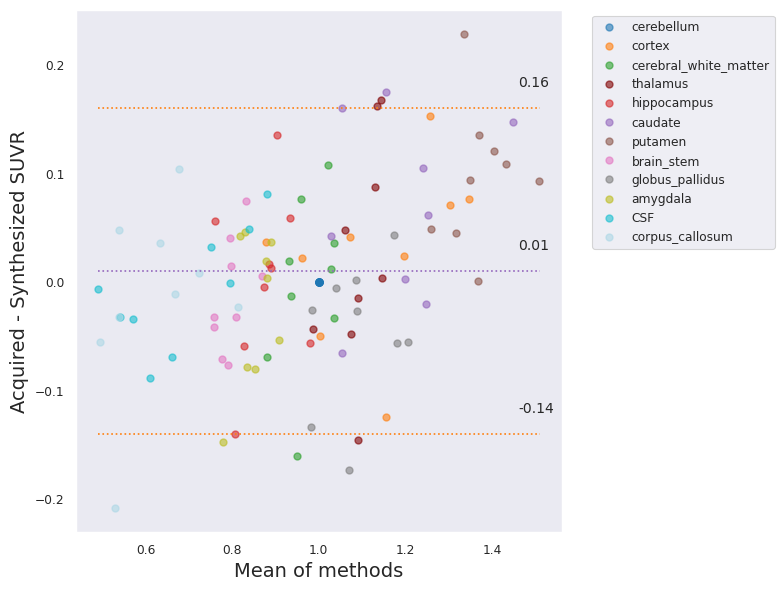

In [35]:
global_bland_altman(combined_suvr_df, exp_types[0], 'truth', TARGET_ROIS, None)

In [43]:
combined_hemi_diff_df

,subject,pet_type,cerebellum_left,cerebellum_right,cerebellum_diff,cortex_left,cortex_right,cortex_diff,cerebral_white_matter_left,cerebral_white_matter_right,...,thalamus_diff,putamen_left,putamen_right,putamen_diff,globus_pallidus_left,globus_pallidus_right,globus_pallidus_diff,amygdala_left,amygdala_right,amygdala_diff
0,25120,truth,1.002817,0.996722,0.003048,1.196504,1.222298,-0.010664,0.922765,0.934540,...,-0.006829,1.360029,1.315746,0.016550,0.988082,1.163930,-0.081713,0.883004,0.881446,0.000883
1,25120,vpsde_dds_step_100,1.002546,0.996728,0.002910,1.173804,1.196883,-0.009735,0.938591,0.944898,...,0.006714,1.320756,1.264706,0.021679,1.027158,1.177554,-0.068215,0.902545,0.862220,0.022850
2,25131,truth,0.994325,1.005717,-0.005696,1.379264,1.388731,-0.003420,1.032632,1.034882,...,-0.028337,1.566506,1.542581,0.007695,1.226739,1.090489,0.058798,0.921390,0.852432,0.038875
3,25131,vpsde_dds_step_100,0.994678,1.005042,-0.005183,1.301075,1.314293,-0.005054,1.021315,1.022568,...,0.017827,1.492393,1.432413,0.020507,1.219359,1.198100,0.008794,0.945621,0.925948,0.010512
4,case-0271,truth,0.986104,1.014386,-0.014137,1.370605,1.306654,0.023886,1.073281,1.034110,...,0.011084,1.534444,1.436270,0.033047,1.013300,0.928390,0.043730,0.958905,0.859191,0.054845
5,case-0271,vpsde_dds_step_100,0.998714,1.001014,-0.001150,1.258417,1.278013,-0.007726,1.008792,1.027654,...,-0.013968,1.386912,1.365999,0.007596,0.986162,1.007746,-0.010825,0.870648,0.869722,0.000532
6,1559_06282016,truth,0.971597,1.035674,-0.031922,1.084219,0.853159,0.119264,1.029890,0.846940,...,0.104904,1.360084,1.191103,0.066237,1.247190,1.094061,0.065405,0.877511,0.780312,0.058630
7,1559_06282016,vpsde_dds_step_100,1.005152,0.993229,0.005966,1.046174,0.847026,0.105191,1.004492,0.833081,...,0.063518,1.266453,1.194313,0.029316,1.251357,1.212340,0.015837,0.826829,0.750983,0.048070
8,25074,truth,1.020698,0.979677,0.020507,1.323148,1.344735,-0.008091,0.987622,1.008681,...,-0.034546,1.397988,1.392214,0.002069,1.076031,1.003642,0.034808,0.816579,0.869795,-0.031556
9,25074,vpsde_dds_step_100,1.019214,0.980852,0.019181,1.179078,1.182929,-0.001630,0.918989,0.923462,...,0.000556,1.300670,1.301248,-0.000222,1.077615,1.012659,0.031075,0.811354,0.802321,0.005598


[-0.03192218 -0.01391298  0.02050688  0.00304844 -0.00569567  0.00285203
 -0.01617058 -0.01413744  0.01000899] [ 0.00596628  0.00258558  0.0191807   0.00291001 -0.00518303  0.00734367
 -0.00519146 -0.00115032  0.00494692]
[ 0.11926438 -0.03563653 -0.0080911  -0.01066417 -0.00342016 -0.04915382
  0.04935451  0.02388648 -0.00019313] [ 0.10519104 -0.01401587 -0.00163036 -0.00973497 -0.00505373 -0.03617557
  0.02617451 -0.00772563 -0.00026082]
[ 0.09747834 -0.00930773 -0.01054898 -0.00634021 -0.00108838 -0.03189687
  0.028109    0.01858751  0.00640282] [ 0.09328117  0.00414125 -0.00242759 -0.00334875 -0.00061286 -0.03159413
  0.01577474 -0.00926239  0.00401078]
[ 0.12368047 -0.04795676 -0.0246414  -0.00071559  0.0284542  -0.01650052
  0.02788188  0.01295899  0.12537324] [ 0.14603311 -0.02028347 -0.0029283   0.00989688  0.02675415 -0.01728199
  0.06297948 -0.00732509  0.05601096]
[ 0.11982153 -0.00260078  0.0180062  -0.00126266  0.01524215  0.01601988
 -0.02494616  0.06265241  0.01295293] [

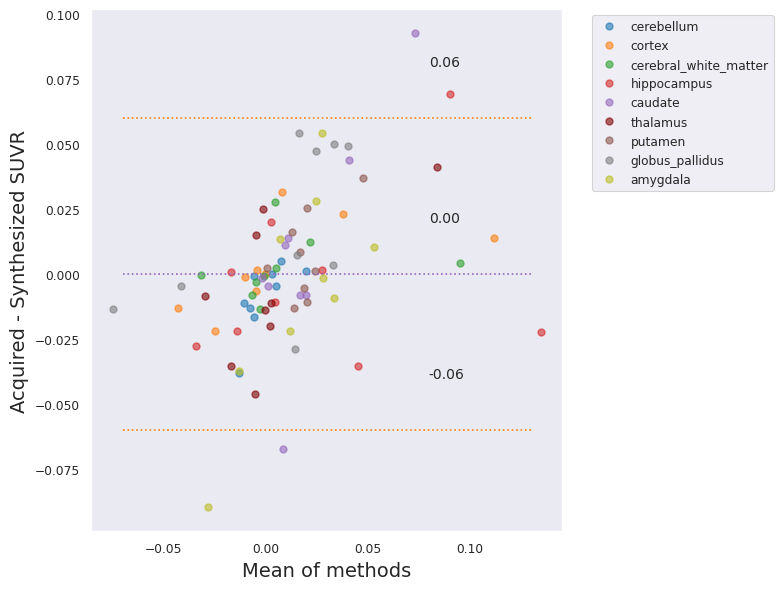

In [44]:
global_bland_altman_asymmetry(combined_hemi_diff_df, exp_types[0], 'truth', LR_ROIS, None)